## Requirements

In [77]:
import sddk
import tempun

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import tempun
import math

In [2]:
# to export figures to sciencedata.dk, you need to login using the sddk package (https://pypi.org/project/sddk/)
# otherwise feel to skip this one and respective cells below
s = sddk.cloudSession("sciencedata.dk", "SDAM_root/SDAM_data/ECCE_public", "648597@au.dk")

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/


# Vector example

In [3]:
J11 = "In the beginning was the Word, and the Word was with God, and the Word was God."
J12 = "He was in the beginning with God"

In [4]:
J11_tok = ["beginning", "to_be", "Word", "Word", "to_be", "God", "Word", "to_be", "God"]
J12_tok = ["to_be", "beginning", "God"]
corpus = [" ".join(doc) for doc in [J11_tok, J12_tok]]
corpus

['beginning to_be Word Word to_be God Word to_be God', 'to_be beginning God']

In [5]:
vocab = ["Word", "God"]

In [6]:
model = CountVectorizer(vocabulary=vocab, lowercase=False)
X = model.fit_transform(corpus)
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0)
V = np.array(X.todense().T)
X = np.array(X.todense())
print(X)
print(V)

[[3 2]
 [0 1]]
[[3 0]
 [2 1]]


In [7]:
Xc.todense()

matrix([[0, 6],
        [6, 0]])

CPU times: user 22.7 ms, sys: 1.65 ms, total: 24.4 ms
Wall time: 24.8 ms


Text(0, 0.5, '$\\it{y}$ ("God")')

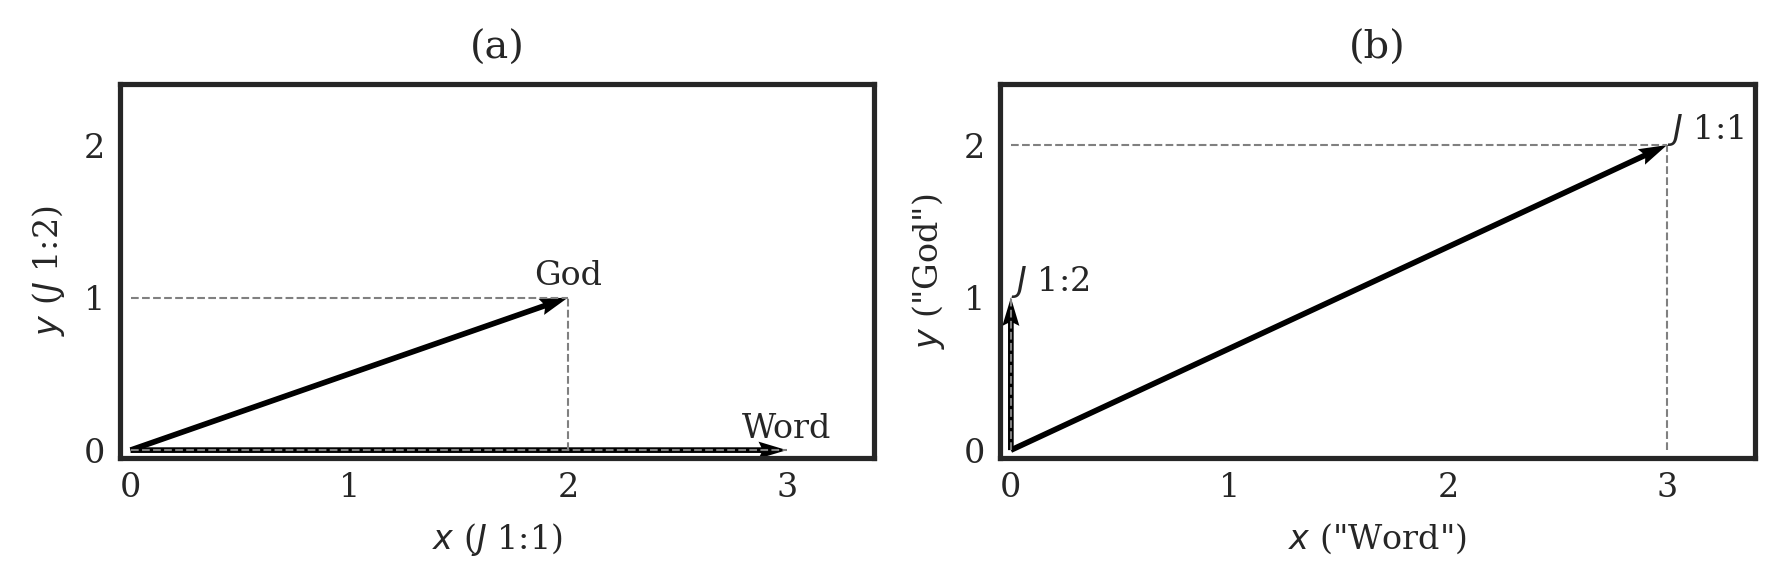

In [8]:
%%time 
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8


fig, [ax1, ax2] = plt.subplots(1,2, figsize=(6, 2), tight_layout=True)

ax1.set_title("(a)")

origin = np.array([[0, 0],[0, 0]]) # origin point
ax1.quiver(*origin, V[:,0], V[:,1], color="black", scale=1, scale_units="xy", angles="xy") #, ax=ax1)#, scale=21)


yshift = 0.08
for word, xy in zip(vocab, V):
    ax1.text(xy[0], xy[1] + yshift, word.replace("_", " "), horizontalalignment="center")
    ax1.hlines(xy[1], 0, xy[0], linestyles="dashed", linewidth=0.5, color="gray")
    ax1.vlines(xy[0], 0, xy[1], linestyles="dashed", linewidth=0.5, color="gray")

ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_yticks([0, 1, 2])

ax1.set_xlabel("$\it{x}$ ($\it{J}$ 1:1)")
ax1.set_ylabel("$\it{y}$ ($\it{J}$ 1:2)")


ax1.set_xlim([-0.05, 3.4])
ax1.set_ylim([-0.05, 2.4])


ax2.set_title("(b)")

ax2.quiver(*origin, X[:,0], X[:,1], color="black", scale=1, scale_units="xy", angles="xy") #, scale=21)
ax2.set_xlim([-0.05, 3.4])
ax2.set_ylim([-0.05, 2.4])

yshift = 0.04
for doc, xy in zip(["$\it{J}$ 1:1", "$\it{J}$ 1:2"], X):
    ax2.text(xy[0], xy[1] + yshift, doc, horizontalalignment="left")
    ax2.hlines(xy[1], 0, xy[0], linestyles="dashed", linewidth=0.5, color="gray")
    ax2.vlines(xy[0], 0, xy[1], linestyles="dashed", linewidth=0.5, color="gray")
    ax2.set_xticks([0, 1, 2, 3])
ax2.set_yticks([0, 1, 2])

ax2.set_xlabel("$\it{x}$ (\"Word\")")
ax2.set_ylabel("$\it{y}$ (\"God\")")


In [9]:
#s.write_file("word_vectors.png", fig)

A file with the same name ("word_vectors.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/word_vectors.png"


In [35]:
fig.savefig("../figures/word_vectors.png")

 # Import the data

In [22]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "LAGT_v1-0.json"
print(local_paths)

['/Users/kasev/Projects/ECCE_DIK/data/large_data/LAGT_v1-0.json']


In [14]:
# read the dataset
try:
    LAGT = pd.read_json(local_paths[0])
except:
    LAGT = pd.read_json("https://zenodo.org/record/4971946/files/LAGT_v1-0.json?download=1")
    LAGT.to_json("../data/large_data/LAGT_v1-0.json")

In [17]:
LAGT.head()

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,Epici/-ae,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",3252,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,Historici/-ae,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν...,6068,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ..."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,Biographi,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,10245,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,"̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα,...",1982,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, τῆνος, πηγή,..."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλ..."


In [25]:
morpheus_by_lemma = s.read_file("https://sciencedata.dk/public/8fe7d59de1eafe5f8eaebc0044534606/morpheus_by_lemma.json", "dict")

In [27]:
LAGT.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,Epici/-ae,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",3252,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,Historici/-ae,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν...,6068,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ..."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,Biographi,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,10245,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,"̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα,...",1982,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, τῆνος, πηγή,..."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλ..."


In [28]:
def flat_lemmata(sentences):
    lemmata = [word for sent in sentences for word in sent]
    return lemmata
LAGT["lemmata"] = LAGT["lemmatized_sentences"].apply(flat_lemmata)

LAGT["lemmata_wordcount"] = LAGT.apply(lambda row: len(row["lemmata"]), axis=1)
LAGT["lemmata_wordcount"].sum() # previously we had 13925726, then 13713183, finally 14756899, 14342245

14383627

In [29]:
len(LAGT)

1457

In [30]:
LAGT["n_sentences"].sum()

2891346

In [31]:
LAGT["wordcount"].sum()

31248866

In [32]:
len(LAGT[LAGT["date_avr"]< 4])

1255

In [33]:
LAGT[LAGT["date_avr"]< 4]["n_sentences"].sum()

1784275

In [34]:
LAGT[LAGT["date_avr"]< 4]["wordcount"].sum()

21086074

In [35]:
def random_dates_from_avr_cent(avr_cent, n=100):
    if str(avr_cent)[-1] == "5":
        return [avr_cent * 100] * 100
    else:
        random_dates = list((np.random.choice((-0.5, 0.5), size=100) + avr_cent) * 100) 
        return random_dates

LAGT["random_dates"] = LAGT["date_avr"].apply(random_dates_from_avr_cent)

# δικ* over the whole corpus

In [36]:
# whole corpus as a list of lemmata
LAGT_lemmata_list = np.concatenate(LAGT["lemmata"].tolist())
len(LAGT_lemmata_list)

14383627

In [37]:
match_pattern = "(κατα|ὑπό|ἐκ|ἀ|ἄ|ἀντί|^)δ[ι|ί]κ(α|ά|ο|ό|ί|έ|η)(.+)?"

dik_words = [word for word in LAGT_lemmata_list if re.search(match_pattern, word)]
dik_words_df = pd.DataFrame(nltk.FreqDist(dik_words).most_common(), columns=["lemma", "count"])
dik_words_df.head(5)

,lemma,count
0,δίκαιος,12961
1,δίκη,6754
2,ἀδικέω,4745
3,δικαιοσύνη,4486
4,ἄδικος,2993


In [38]:
def lemma_translator(word):
    try:
        translations = []
        for option in word.split("/"):
            translations.append(" / ".join(set([token["s"] for token in morpheus_by_lemma[option]])))
            translations = " / ".join(translations)
    except:
        translations = ""
    return translations

In [39]:
dik_words_df["translation"] = dik_words_df["lemma"].apply(lemma_translator)
dik_words_df.head(12)

,lemma,count,translation
0,δίκαιος,12961,"observant of custom and social rule, well-orde..."
1,δίκη,6754,"custom, usage"
2,ἀδικέω,4745,to do wrong
3,δικαιοσύνη,4486,"righteousness, justice"
4,ἄδικος,2993,"wrong-doing, unrighteous, unjust"
5,δικαστής,2493,a judge
6,ἀδικία,2053,"wrong-doing, injustice"
7,δικαστήριον,1432,a court of justice
8,δικάζω,1054,"to judge, to give judgment on"
9,ἀδίκημα,1032,"a wrong done, a wrong"


In [25]:
dik_words_df.to_csv("../data/dik_words.csv")

# Chronological overview

In [40]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη"]

In [41]:
def count_words_in_df_column(docs, words, wordcount=None):
    '''
    Parameters
    ----------
    docs : `pandas.Series` consisting of lists
        List or series of lists, each list representing a tokenized (and lemmatized) version of a document
    words : `list`
        List of words to be counted
    
    Returns
    -------
    `dict`
        Dictionary of word : count pairs
    '''
    counts_dict = {}
    weighted_sum = 0
    for word in words:
        count = docs.apply(lambda doc_list: doc_list.count(word)).sum()
        counts_dict[word] = count
        if wordcount != None:
            if wordcount > 0:
                weighted = np.round(count / wordcount, 5)
                counts_dict[word + "_weighted"] = weighted
                weighted_sum += weighted
    counts_dict["weighted_sum"] = weighted_sum
    return counts_dict

In [42]:
LAGT.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,random_dates
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,Epici/-ae,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",3252,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ...","[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσκ...",23777,"[-250.0, -250.0, -250.0, -250.0, -250.0, -250...."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,Historici/-ae,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν...,6068,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",71863,"[-450.0, -450.0, -450.0, -450.0, -450.0, -450...."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,Biographi,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,10245,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ...","[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχω...",56872,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,"̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα,...",1982,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, τῆνος, πηγή,...","[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, τῆνος, πηγή, ...",11879,"[-350.0, -250.0, -250.0, -350.0, -250.0, -350...."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλ...","[ῥόδον, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλ...",1077,"[-350.0, -250.0, -350.0, -350.0, -250.0, -350...."


In [43]:
dates_list = [date / 100 for date in range(-750, 400, 50)]
print(dates_list)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [44]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [45]:
date_avr_to_string(0.0)

'1 BCE/1 CE'

In [46]:
date_avr_to_string(0.5)

'1 CE'

In [47]:
subselections = []
for date in dates_list:
    subselection = LAGT[LAGT["date_avr"]== date]
    wordcount_christian = LAGT[(LAGT["date_avr"]== date) & (LAGT["provenience"]=="christian")]["wordcount"].sum()
    wordcount_pagan = LAGT[(LAGT["date_avr"]== date) & (LAGT["provenience"]!="christian")]["wordcount"].sum()
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount, "wordcount_christian" : wordcount_christian, "wordcount_pagan" : wordcount_pagan, "doccount": doccount}
    subselection_dict.update(count_words_in_df_column(subselection["lemmata"], words, wordcount))
    subselections.append(subselection_dict)

In [48]:
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,wordcount_christian,wordcount_pagan,doccount,δίκαιος,δίκαιος_weighted,δίκη,δίκη_weighted,δικαιοσύνη,δικαιοσύνη_weighted,weighted_sum
0,8 BCE,date_avr,-7.5,199822,0,199822,3,15,0.00008,17,0.00009,0,0.00000,0.00017
1,8/7 BCE,date_avr,-7.0,16193,0,16193,3,9,0.00056,29,0.00179,0,0.00000,0.00235
2,7 BCE,date_avr,-6.5,144,0,144,1,0,0.00000,0,0.00000,0,0.00000,0.00000
3,7/6 BCE,date_avr,-6.0,9268,0,9268,3,1,0.00011,2,0.00022,0,0.00000,0.00033
4,6 BCE,date_avr,-5.5,39711,0,39711,2,19,0.00048,11,0.00028,2,0.00005,0.00081
5,6/5 BCE,date_avr,-5.0,66272,0,66272,14,34,0.00051,135,0.00204,0,0.00000,0.00255
6,5 BCE,date_avr,-4.5,558265,0,558265,35,362,0.00065,364,0.00065,9,0.00002,0.00132
7,5/4 BCE,date_avr,-4.0,1557973,0,1557973,197,1416,0.00091,784,0.00050,349,0.00022,0.00163
8,4 BCE,date_avr,-3.5,1278461,0,1278461,121,1522,0.00119,703,0.00055,179,0.00014,0.00188
9,4/3 BCE,date_avr,-3.0,207682,0,207682,28,59,0.00028,32,0.00015,4,0.00002,0.00045


CPU times: user 114 ms, sys: 121 ms, total: 235 ms
Wall time: 272 ms


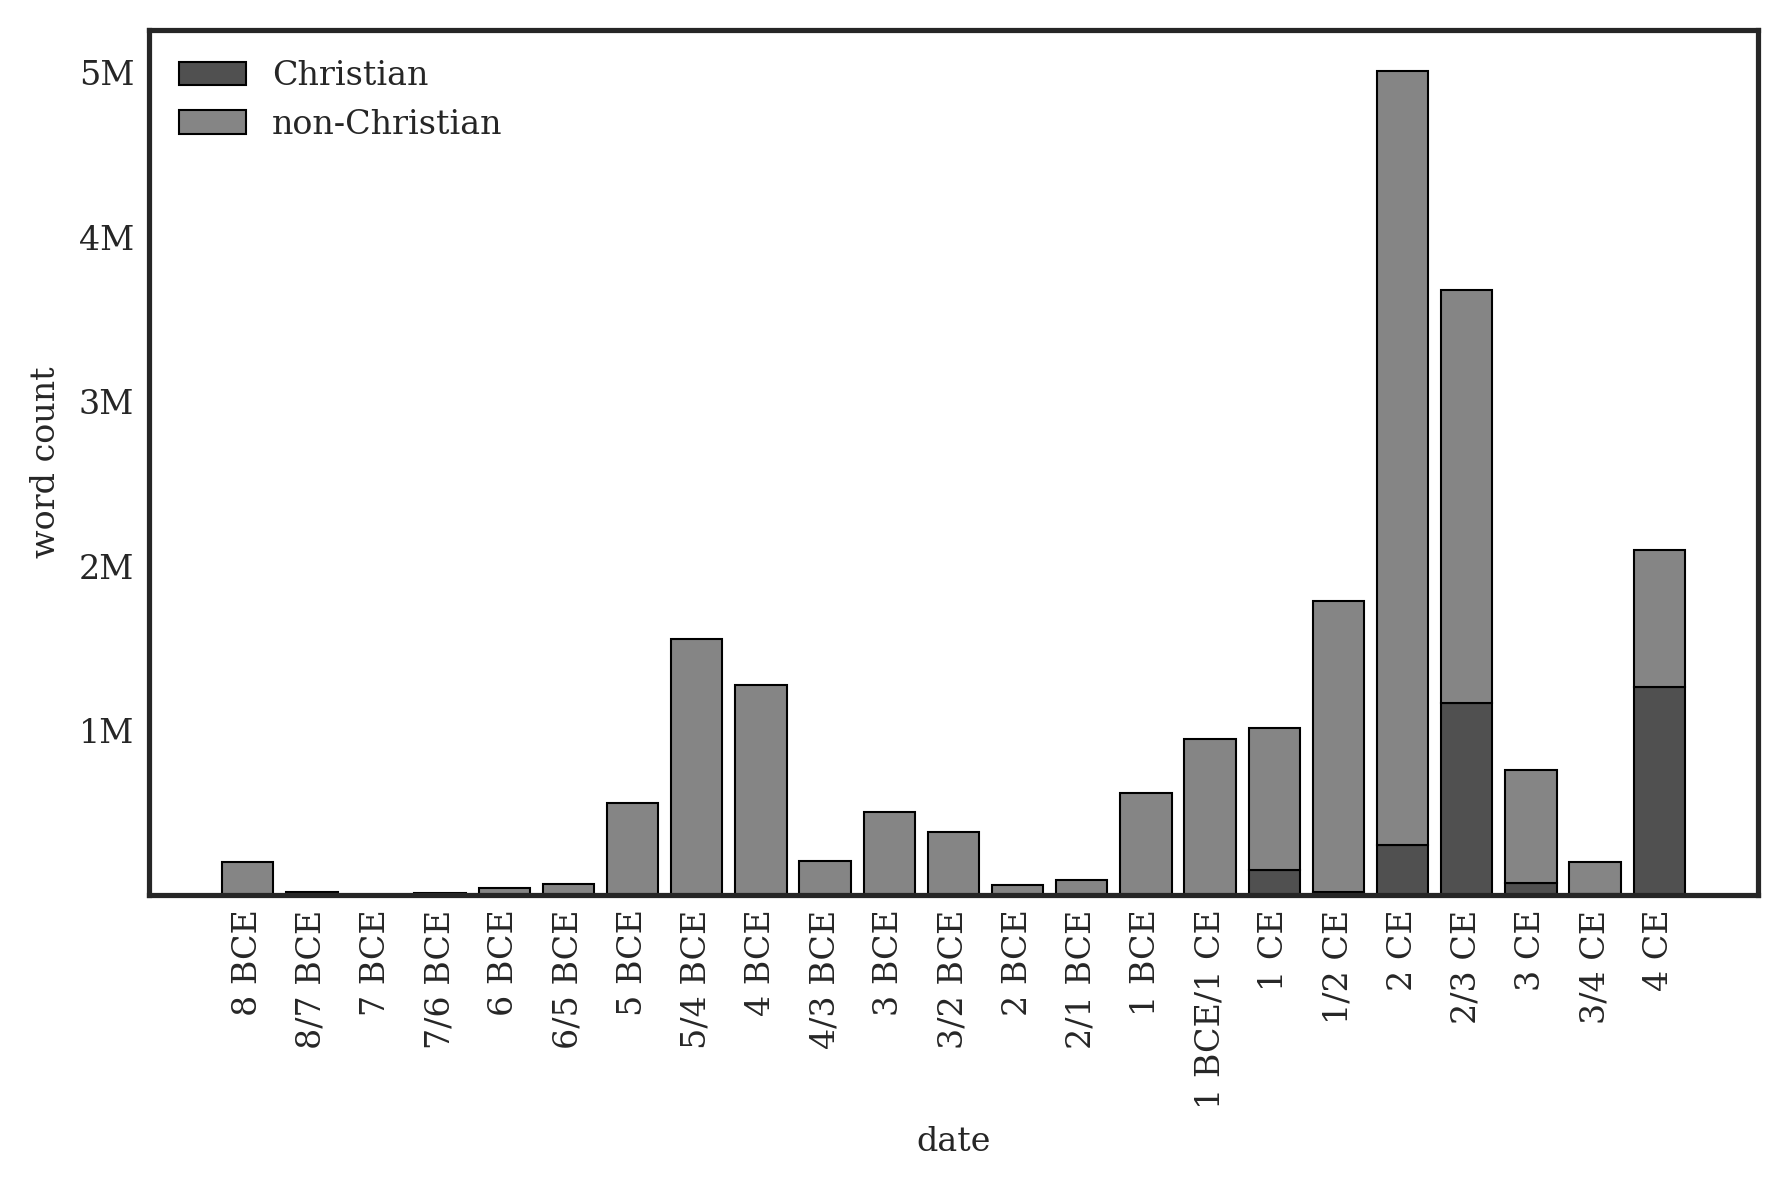

In [49]:
%%time 
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
#subselections_df = subselections_df.iloc[::-1]
ax.bar(subselections_df["date_string"], subselections_df["wordcount_christian"], color="#505050", label="Christian", edgecolor="black", linewidth=0.5)
ax.bar(subselections_df["date_string"], subselections_df["wordcount_pagan"], bottom=subselections_df["wordcount_christian"], label="non-Christian", color="#858585", edgecolor="black", linewidth=0.5)


ax.set_yticks(range(1000000,6000000, 1000000))
ax.set_yticklabels(str(n) + "M" for n in range(1,6))
ax.set_xticklabels(subselections_df["date_string"], rotation=90)
ax.set_xlabel("date")
ax.set_ylabel("word count")
ax.legend()
#plt.title("AGT corpus overview")

In [179]:
# s.write_file("/corpus_overview.png", fig)
fig.savefig("../figures/corpus_overview.png")

A file with the same name ("corpus_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public//corpus_overview.png"


In [50]:
def plot_ratios(corpus_df, label_col, height=4, morelines=False):
    plt.style.use("seaborn-white")
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['font.size'] = 8
    corpus_df = corpus_df[::-1]
    data = {}
    for n in range(len(corpus_df)):
        if morelines==True:
            label = str(corpus_df.iloc[n][label_col]) + "\n(" + str(corpus_df.iloc[n]["doccount"]) + " docs; " + str(corpus_df.iloc[n]["wordcount"]) + " words)"
        else:
            label = str(corpus_df.iloc[n][label_col]) + "(" + str(corpus_df.iloc[n]["doccount"]) + " docs; " + str(corpus_df.iloc[n]["wordcount"]) + " words)"
        counts = corpus_df.iloc[n][words].tolist()
        values = corpus_df.iloc[n][[word + "_weighted" for word in words]].tolist()
        values = [0 if math.isnan(x) else x for x in values]
        ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
        ratios = [0 if math.isnan(x) else x for x in ratios]
        data[label] = (counts, ratios)

    labels = list(data.keys())
    counts = np.array([el[0] for el in list(data.values())])
    ratios = np.array([el[1] for el in list(data.values())])
    ratios_cum = ratios.cumsum(axis=1)


    terms = words


    fig, ax = plt.subplots(figsize=(6, height), tight_layout=True)# len(corpus_df)/5 + 1)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)

    ax.set_xlim(0, np.sum(ratios, axis=1).max())
    ax.set_ylim(-0.5, len(corpus_df) - 0.5)

    colors=["#A0A0A0", "#606060", "#202020"]

    for i, (term, hatch, color) in enumerate(zip(terms, ["/", "x", "\\"], colors)):
        widths = ratios[:, i]
        texts = counts[:, i]
        starts = ratios_cum[:, i] - widths
        bar = ax.barh(labels, widths, left=starts,
                      label=term, color=color, edgecolor="black", linewidth=0.5)#, hatch=hatch*3)
        xcenters = starts + widths / 2
        for y, (x, c) in enumerate(zip(xcenters, texts)):
            if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
            else:
                ax.text(x, y, "", ha='center', va='center', color='white')
    ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left')
    return fig

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_32840/2812402767.py:16: RuntimeWarning: invalid value encountered in double_scalars
  ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]


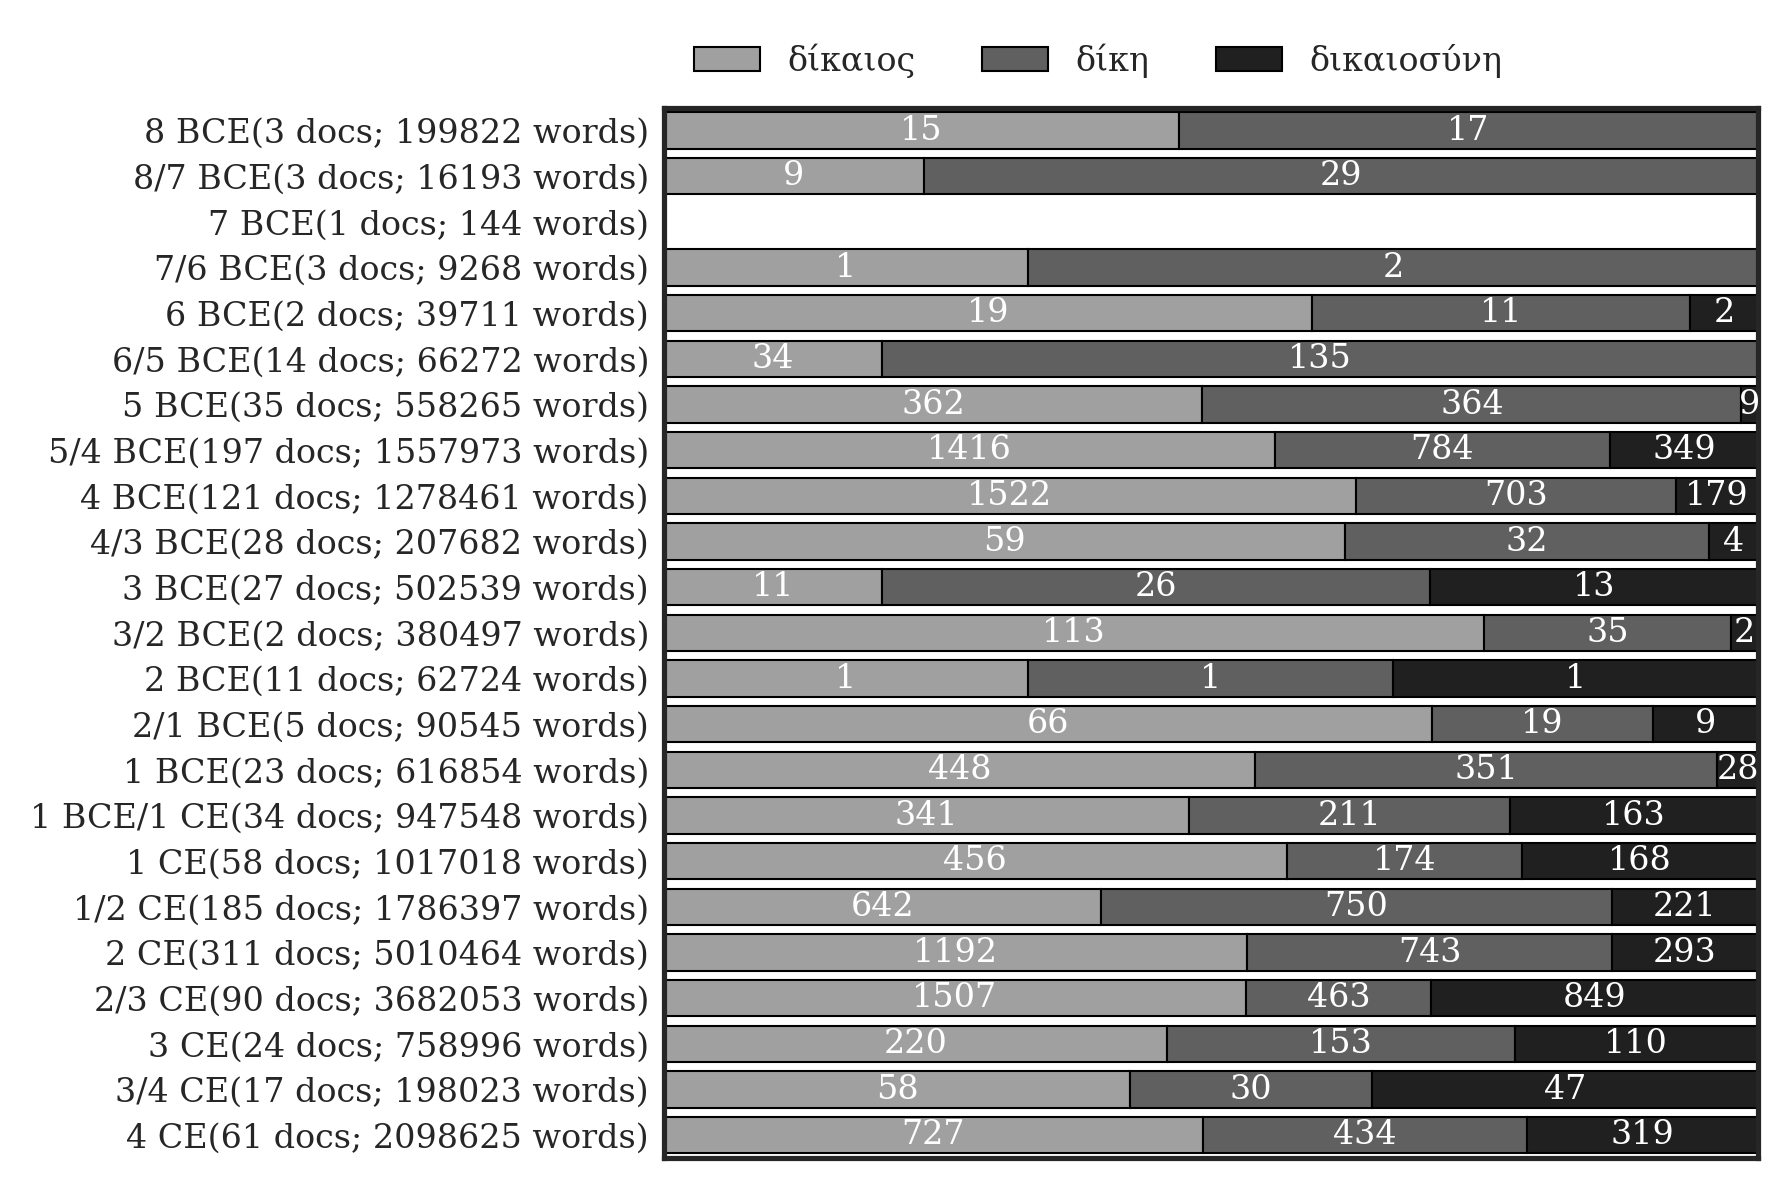

In [51]:
fig = plot_ratios(subselections_df, "date_string")

In [52]:
s.write_file("ratios_diachronical.png", fig)
fig.savefig("../figures/ratios_diachronical.png")

A file with the same name ("ratios_diachronical.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/ratios_diachronical.png"


# Overview based on subcorpora

In [54]:
subcorpora_dict = {
    "Pagan (8th c. BCE - 4th c. CE)" :LAGT[(LAGT["provenience"]=="pagan") & (LAGT["date_avr"] < 4)],
    "Pagan (1st - 4th c. CE)" :LAGT[(LAGT["date_avr"].between(0, 4)) & (LAGT["provenience"]=="pagan")],
    "Septuagint" :LAGT[LAGT["author_id"]=="tlg0527"],
    "Philo of Alexandria" :LAGT[LAGT["author_id"]=="tlg0018"],
    "Titus Flavius Josephus" :LAGT[LAGT["author_id"]=="tlg0526"],
    "Paul of Tarsus" :LAGT[LAGT["author_id"]=="tlg0031paul"],
    "New Testament" :LAGT[LAGT["author_id"].str.startswith("tlg0031")],
    "Christian (1st - 4th c. CE)" :LAGT[(LAGT["date_avr"] < 4) & (LAGT["provenience"]=="christian")]}

In [55]:
subselections = []
for key in subcorpora_dict.keys():
    subselection = subcorpora_dict[key]
    subselection_dict = {}
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    subselection_dict.update({"label" : key, "wordcount" : wordcount, "doccount" : doccount})
    subselection_dict.update(count_words_in_df_column(subselection["lemmata"], words, wordcount))
    subselections.append(subselection_dict)


In [56]:
subselections_df = pd.DataFrame(subselections)
subselections_df

,label,wordcount,doccount,δίκαιος,δίκαιος_weighted,δίκη,δίκη_weighted,δικαιοσύνη,δικαιοσύνη_weighted,weighted_sum
0,Pagan (8th c. BCE - 4th c. CE),12965219,774,5153,0.00040,3484,0.00027,1153,0.00009,0.00076
1,Pagan (1st - 4th c. CE),8692448,411,1885,0.00022,1506,0.00017,618,0.00007,0.00046
2,Septuagint,799083,55,433,0.00054,45,0.00006,341,0.00043,0.00103
3,Philo of Alexandria,643011,31,310,0.00048,172,0.00027,157,0.00024,0.00099
4,Titus Flavius Josephus,469580,4,296,0.00063,156,0.00033,39,0.00008,0.00104
5,Paul of Tarsus,24066,7,10,0.00042,0,0.00000,49,0.00204,0.00246
6,New Testament,137787,27,79,0.00057,4,0.00003,91,0.00066,0.00126
7,Christian (1st - 4th c. CE),2975644,131,1748,0.00059,557,0.00019,1095,0.00037,0.00115


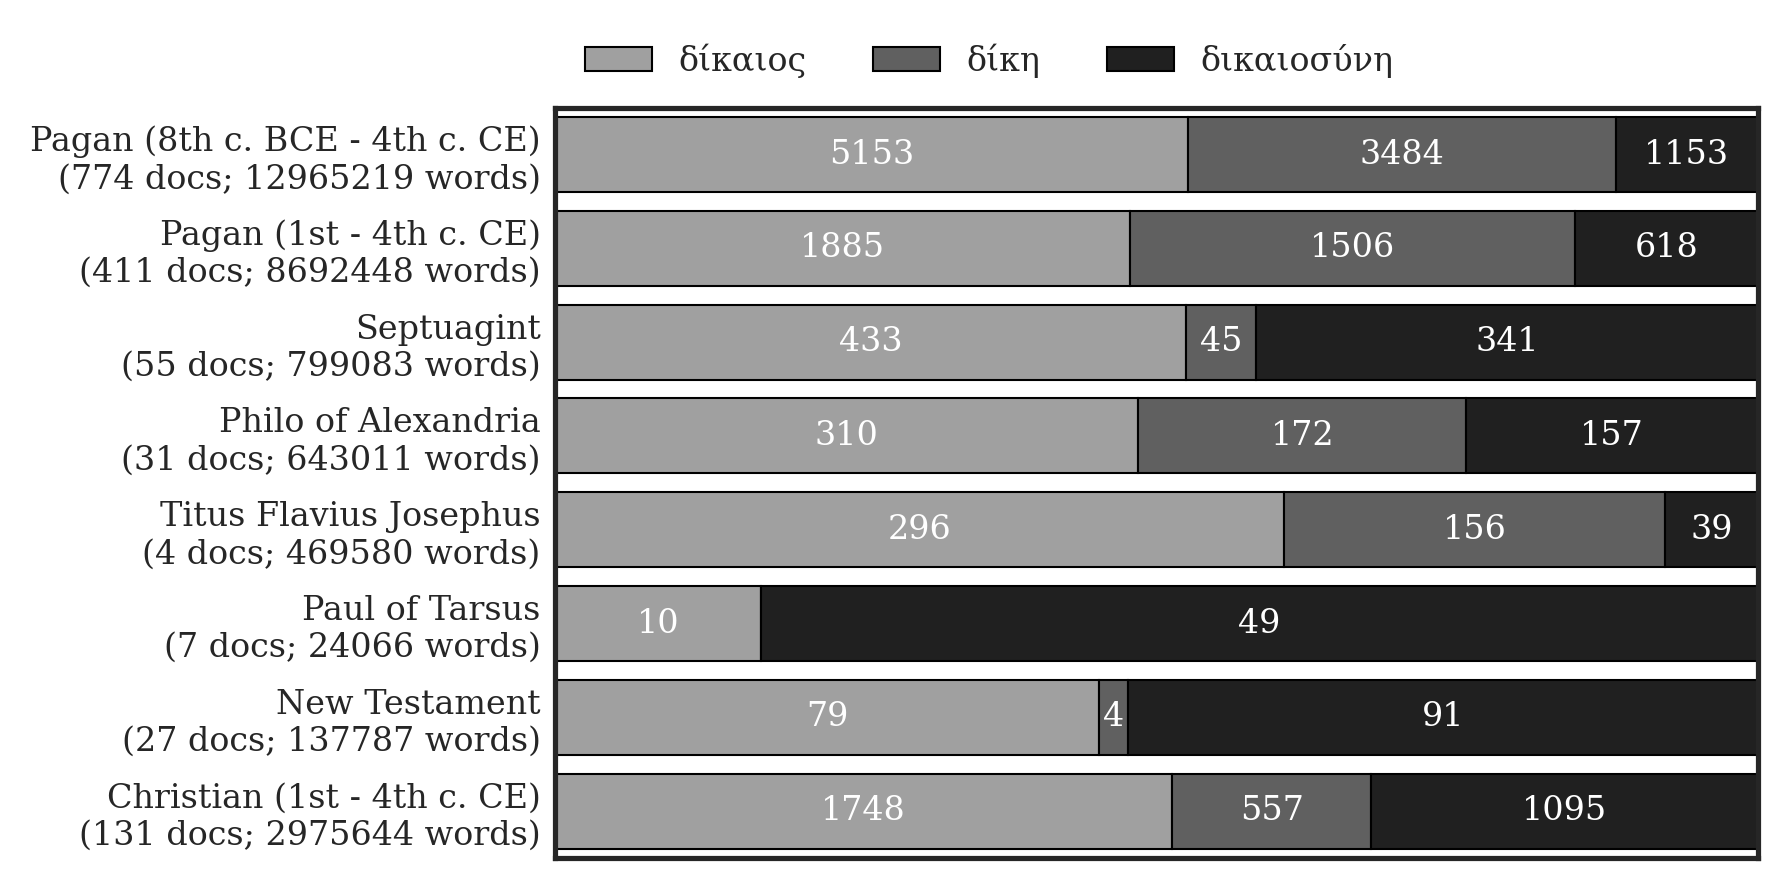

In [57]:
fig = plot_ratios(subselections_df, "label", morelines=True, height=3)

In [58]:
s.write_file("subcorpora_ratios.png", fig)
fig.savefig("../figures/subcorpora_ratios.png")

A file with the same name ("subcorpora_ratios.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/subcorpora_ratios.png"


In [190]:
subselections_df = subselections_df.iloc[::-1]

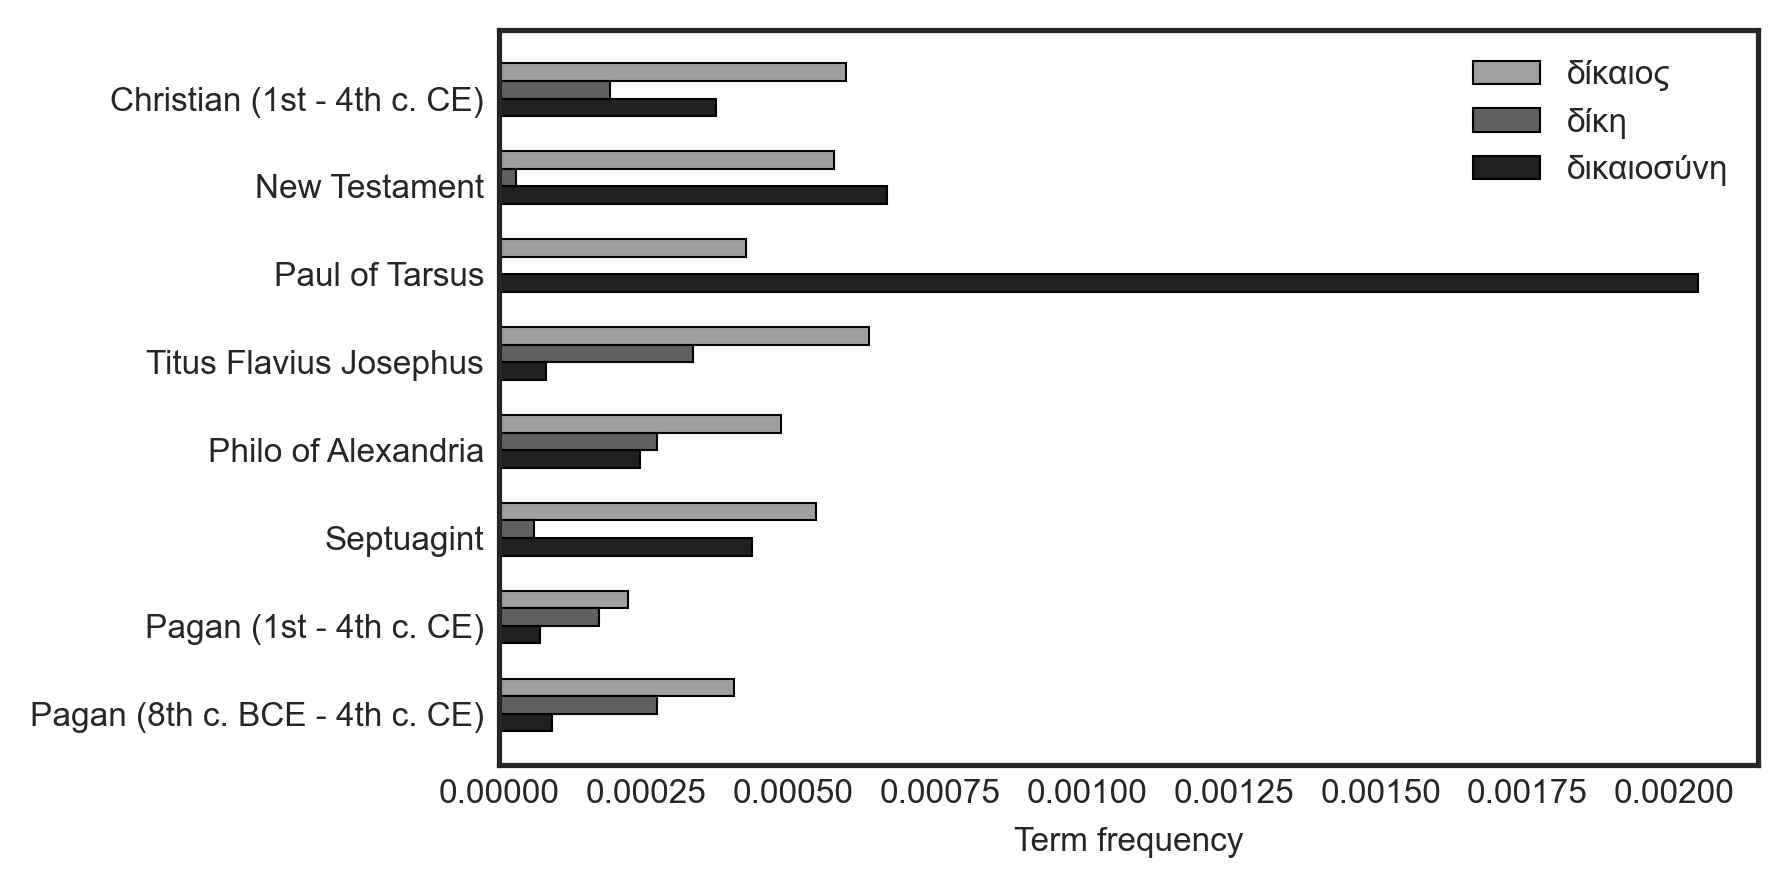

In [59]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)

y = np.arange(len(subselections_df))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, color in [("δίκαιος_weighted", "#A0A0A0"), ("δίκη_weighted", "#606060"), ("δικαιοσύνη_weighted", "#202020")]:
  #coloring = subselections_df[keyterm + "_weighted"] / subselections_df["weighted_sum"].max()
  ax.barh(y + 0.3 - bar_location, subselections_df[keyterm], width, color=color, label=keyterm.partition("_")[0], edgecolor="black", linewidth=0.5)
  bar_location = bar_location + 0.2
#ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel("Term frequency")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(subselections_df["label"])

plt.legend()


In [60]:
s.write_file("subcorpora_overview.png", fig)
fig.savefig("../figures/subcorpora_overview.png")

A file with the same name ("subcorpora_overview.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/subcorpora_overview.png"


# PHI overview

In [61]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "PHI_v1.0.json"
print(local_paths)

['/Users/kasev/Projects/RBB_commentary/data/large_files/PHI_v1.0.json']


In [62]:
# load the PHI dataset
# check whether it is available locally somewhere
# otherwise download it from zenodo
# (takes some time - the dataset has almost 400MB)
try:
    PHI = pd.read_json(local_paths[0])
except:
    PHI = pd.read_json("https://zenodo.org/record/4972968/files/PHI_v1.0.json?download=1")
    PHI.to_json("../data/large_data/PHI_v1.0.json")
# print first 5 rows of the data
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,...,lem_sents,lemmata,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
0,/text/1?location=1701&patt=&bookid=4&offset=0&...,IG I³,1,Regions\nAttica (IG I-III),IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,,12,1\n\n\n\n5\n\n\n\n\n10\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,...,"[[ἔδοχσεν, δέμοι, Σαλαμίς, κλερόχος, οἰκεν, Σα...","[ἔδοχσεν, δέμοι, Σαλαμίς, κλερόχος, οἰκεν, Σαλ...",c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
1,/text/2?location=1701&patt=&bookid=4&offset=0&...,IG I³,2,Regions\nAttica (IG I-III),IG I³\n2,Att. — non-stoich. — c. 500 a.,,14,1\n\n\n\n5\n\n\n\n\n10\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,...,"[[βολ, ἑκών, σίον, γνοσθει, ἄτεχνος, μεδὲ, κελ...","[βολ, ἑκών, σίον, γνοσθει, ἄτεχνος, μεδὲ, κελε...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
2,/text/3?location=1701&patt=&bookid=4&offset=0&...,IG I³,3,Regions\nAttica (IG I-III),IG I³\n3,Att. — stoich. 21 — 490-480 a.,,13,1\n\n\n\n5\n\n\n\n\n10\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,...,"[[ἑρακλειο, ἀρόω, τίθημι, ἀθλοθέτης, ἀνήρ, ἄγο...","[ἑρακλειο, ἀρόω, τίθημι, ἀθλοθέτης, ἀνήρ, ἄγον...",490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
3,/text/4?location=1701&patt=&bookid=4&offset=0&...,IG I³,4,Regions\nAttica (IG I-III),IG I³\n4,Att. — stoich. 38 — 485/4 a.,,56,face A.1\n\n\n\n5\n\n\n\n\n10\n\n\n\n\n15\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,...,"[[τὶς, φρορὰν, πεντέκοντα, δραχμή, τ, πρᾶχσιν,...","[τὶς, φρορὰν, πεντέκοντα, δραχμή, τ, πρᾶχσιν, ...",485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
4,/text/5?location=1701&patt=&bookid=4&offset=0&...,IG I³,5,Regions\nAttica (IG I-III),IG I³\n5,Att. — c. 500 a.,,6,1\n\n\n\n5\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,...,"[[ἔδοχσεν, τει, βολει, δέμοι, παραιβάτες, γραμ...","[ἔδοχσεν, τει, βολει, δέμοι, παραιβάτες, γραμμ...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [63]:
PHI.columns

Index(['URL', 'Book', 'Text', 'hdr1', 'hdr2', 'tildeinfo', 'note', 'lines',
       'metadata', 'data', 'filename', 'PHI_ID', 'string_pythia',
       'clean_text_conservative', 'clean_text_interpretive_word',
       'clean_text_interpretive_sentence', 'clean_text_pythia', 'sents',
       'sents_N', 'lem_sents', 'lemmata', 'raw_date', 'dating_dict',
       'not_before', 'not_after', 'or', 'date_tags', 'certainty', 'link'],
      dtype='object')

In [64]:
len(PHI) # previously 216702, then 218162

218162

In [65]:
PHI["wordcount"] = PHI["clean_text_pythia"].apply(lambda string: len(string.split()))

In [66]:
PHI["wordcount"].sum() #4469462, 4509107

4419743

In [67]:
len(PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())]) # 130533

131904

In [68]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη"]
for word in words:
    PHI[word] = PHI["lemmata"].apply(lambda x: x.count(word))

In [69]:
for word in words:
    print(word, PHI[word].sum())

δίκαιος 1398
δίκη 1848
δικαιοσύνη 656


In [70]:
for word in words:
    print(PHI["clean_text_pythia"].apply(lambda x: len(re.findall(word, x))).sum())

98
536
539


In [71]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
PHI["random_dates"] = PHI.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 40.7 s, sys: 1.48 s, total: 42.2 s
Wall time: 42.7 s


In [72]:
PHI_complete_simulations = tempun.timeblocks_from_randoms(PHI, "random_dates", [-800, 400, 50])
# look at the first one
PHI_complete_simulations[0]

[((-800, -751), 9),
 ((-750, -701), 57),
 ((-700, -651), 164),
 ((-650, -601), 260),
 ((-600, -551), 932),
 ((-550, -501), 2058),
 ((-500, -451), 3934),
 ((-450, -401), 4088),
 ((-400, -351), 6218),
 ((-350, -301), 9104),
 ((-300, -251), 8022),
 ((-250, -201), 8991),
 ((-200, -151), 9183),
 ((-150, -101), 7129),
 ((-100, -51), 5077),
 ((-50, -1), 5468),
 ((1, 50), 6289),
 ((51, 100), 6253),
 ((101, 150), 10202),
 ((151, 200), 10025),
 ((201, 250), 8948),
 ((251, 300), 5797),
 ((301, 350), 3223),
 ((351, 400), 2835)]

In [73]:
sub_df = PHI[PHI["δικαιοσύνη"]>0]
sub_df_sim = tempun.timeblocks_from_randoms(sub_df,  "random_dates", [-800, 400, 50])
sub_df_sim[0]
# for timeblock in PHI_complete_simulations[0].keys():

[((-800, -751), 0),
 ((-750, -701), 0),
 ((-700, -651), 0),
 ((-650, -601), 0),
 ((-600, -551), 0),
 ((-550, -501), 1),
 ((-500, -451), 0),
 ((-450, -401), 5),
 ((-400, -351), 33),
 ((-350, -301), 130),
 ((-300, -251), 50),
 ((-250, -201), 52),
 ((-200, -151), 27),
 ((-150, -101), 41),
 ((-100, -51), 19),
 ((-50, -1), 21),
 ((1, 50), 8),
 ((51, 100), 7),
 ((101, 150), 11),
 ((151, 200), 11),
 ((201, 250), 7),
 ((251, 300), 6),
 ((301, 350), 2),
 ((351, 400), 3)]

In [74]:
def get_date_from_randoms(value, n):
    try:
        return value[n]
    except:
        return None

dating_variant = PHI["random_dates"].apply(lambda x: get_date_from_randoms(x, 0))
mask = dating_variant.between(200, 301)
timeblock_df_variant = PHI[mask]

In [75]:
def tf_in_df(df, word):
    wordcount_total = df["wordcount"].sum()
    word_count = df["lemmata"].apply(lambda x: x.count(word)).sum()
    word_freq = word_count / wordcount_total
    return word_freq

In [76]:
def sim_data(df, n_sims, metrics_function, *args):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in tempun.get_timeblocks(-800, 400, 100):
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = metrics_function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

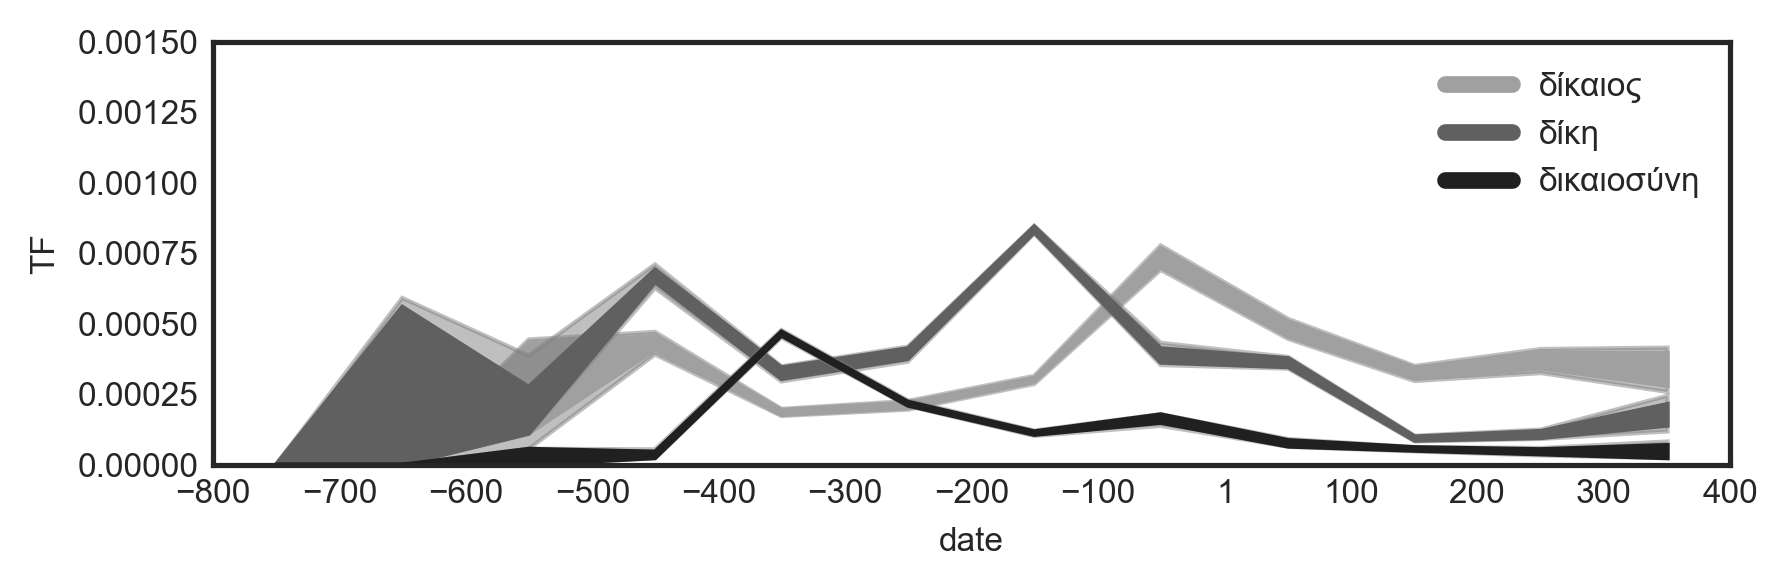

In [79]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 2), tight_layout=True)

markers = []

for word, color in zip(words, ["#A0A0A0", "#606060", "#202020"]):
    complete_sim_data = sim_data(PHI, 100, tf_in_df, word) 
    layer = tempun.plot_timeblocks_data(complete_sim_data, ax=ax, color=color)
    markers.append(mlines.Line2D([], [], linewidth=4, label=word, color=color))

ax.set_xlim(-800, 400)
ax.set_xticks([n + 1 if n == 0 else n for n in range(-800, 500, 100)])
ax.set_xlabel("date")

ax.set_ylim(0, 0.0015)
ax.set_ylabel("TF")

# plt.title("PHI - key terms frequencies (across 100 dating variants)")
ax.legend(handles=markers)

In [81]:
s.write_file("PHI_tf.png",fig)
fig.savefig("../figures/PHI_tf.png")

A file with the same name ("PHI_tf.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/PHI_tf.png"


In [82]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη"]
for word in words:
   LAGT[word] =LAGT["lemmata"].apply(lambda x: x.count(word))

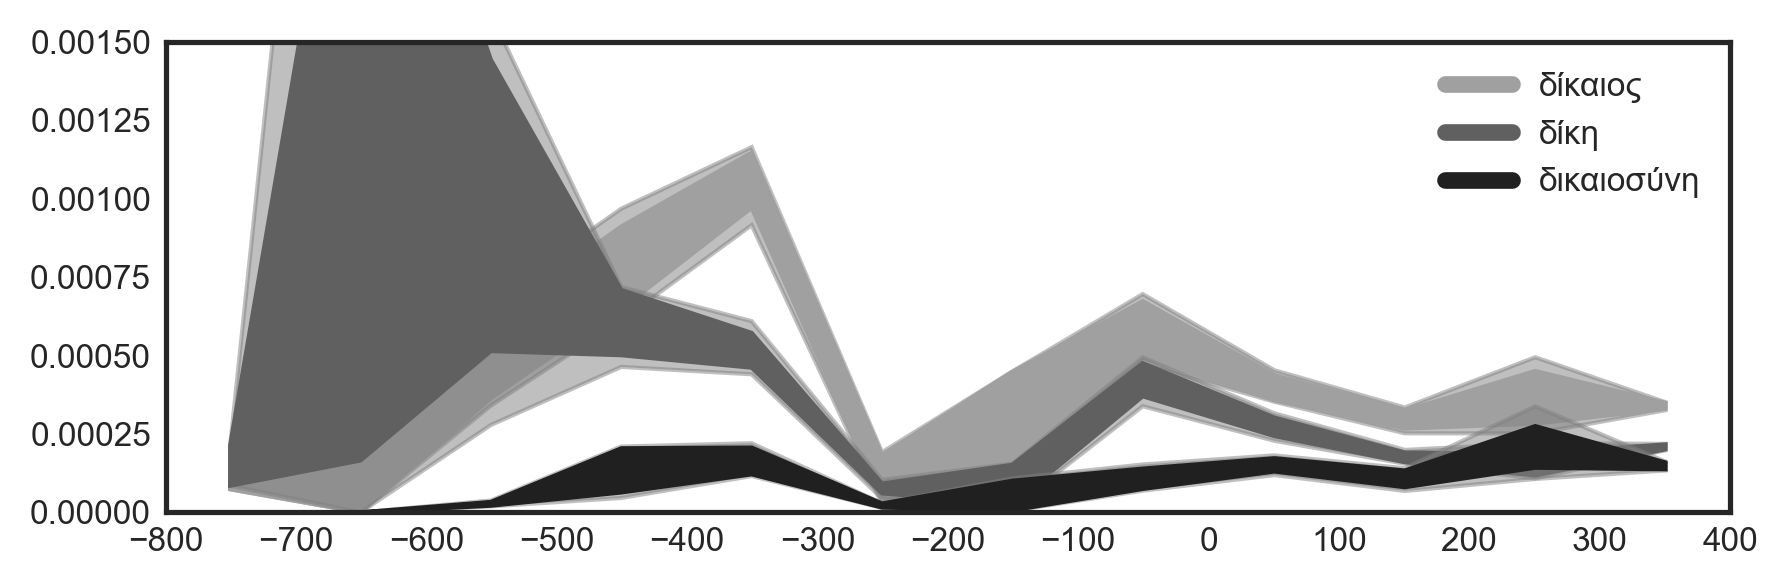

In [83]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 2), tight_layout=True)

markers = []

for word, color in zip(words, ["#A0A0A0", "#606060", "#202020"]):
    complete_sim_data = sim_data(LAGT, 100, tf_in_df, word)
    layer = tempun.plot_timeblocks_data(complete_sim_data, ax=ax, color=color)
    markers.append(mlines.Line2D([], [], linewidth=4, label=word, color=color))

ax.set_xlim(-800, 400)
ax.set_xticks(range(-800, 500, 100))

ax.set_ylim(0, 0.0015)

ax.legend(handles=markers)

In [84]:
LAGT_by_avr = LAGT.groupby("date_avr").sum()[:3.5].reset_index()

In [85]:
for word in words:
   LAGT_by_avr[word + "_TF"] = LAGT_by_avr.apply(lambda row: row[word] / row["wordcount"], axis=1)

In [86]:
LAGT_by_avr

,date_avr,wordcount,date_manual,n_sentences,lemmata_wordcount,δίκαιος,δίκη,δικαιοσύνη,δίκαιος_TF,δίκη_TF,δικαιοσύνη_TF
0,-7.5,199822,-22.5,15216,117836,15,17,0,0.000075,0.000085,0.000000
1,-7.0,16193,-19.5,1183,10345,9,29,0,0.000556,0.001791,0.000000
2,-6.5,144,-7.0,13,88,0,0,0,0.000000,0.000000,0.000000
3,-6.0,9268,-21.0,699,5731,1,2,0,0.000108,0.000216,0.000000
4,-5.5,39711,-5.5,3391,21676,19,11,2,0.000478,0.000277,0.000050
5,-5.0,66272,-70.5,6059,43451,34,135,0,0.000513,0.002037,0.000000
6,-4.5,558265,-148.5,39854,295920,362,364,9,0.000648,0.000652,0.000016
7,-4.0,1557973,-665.0,122693,762122,1416,784,349,0.000909,0.000503,0.000224
8,-3.5,1278461,-357.0,87478,579414,1522,703,179,0.001190,0.000550,0.000140
9,-3.0,207682,-31.5,24391,101071,59,32,4,0.000284,0.000154,0.000019


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


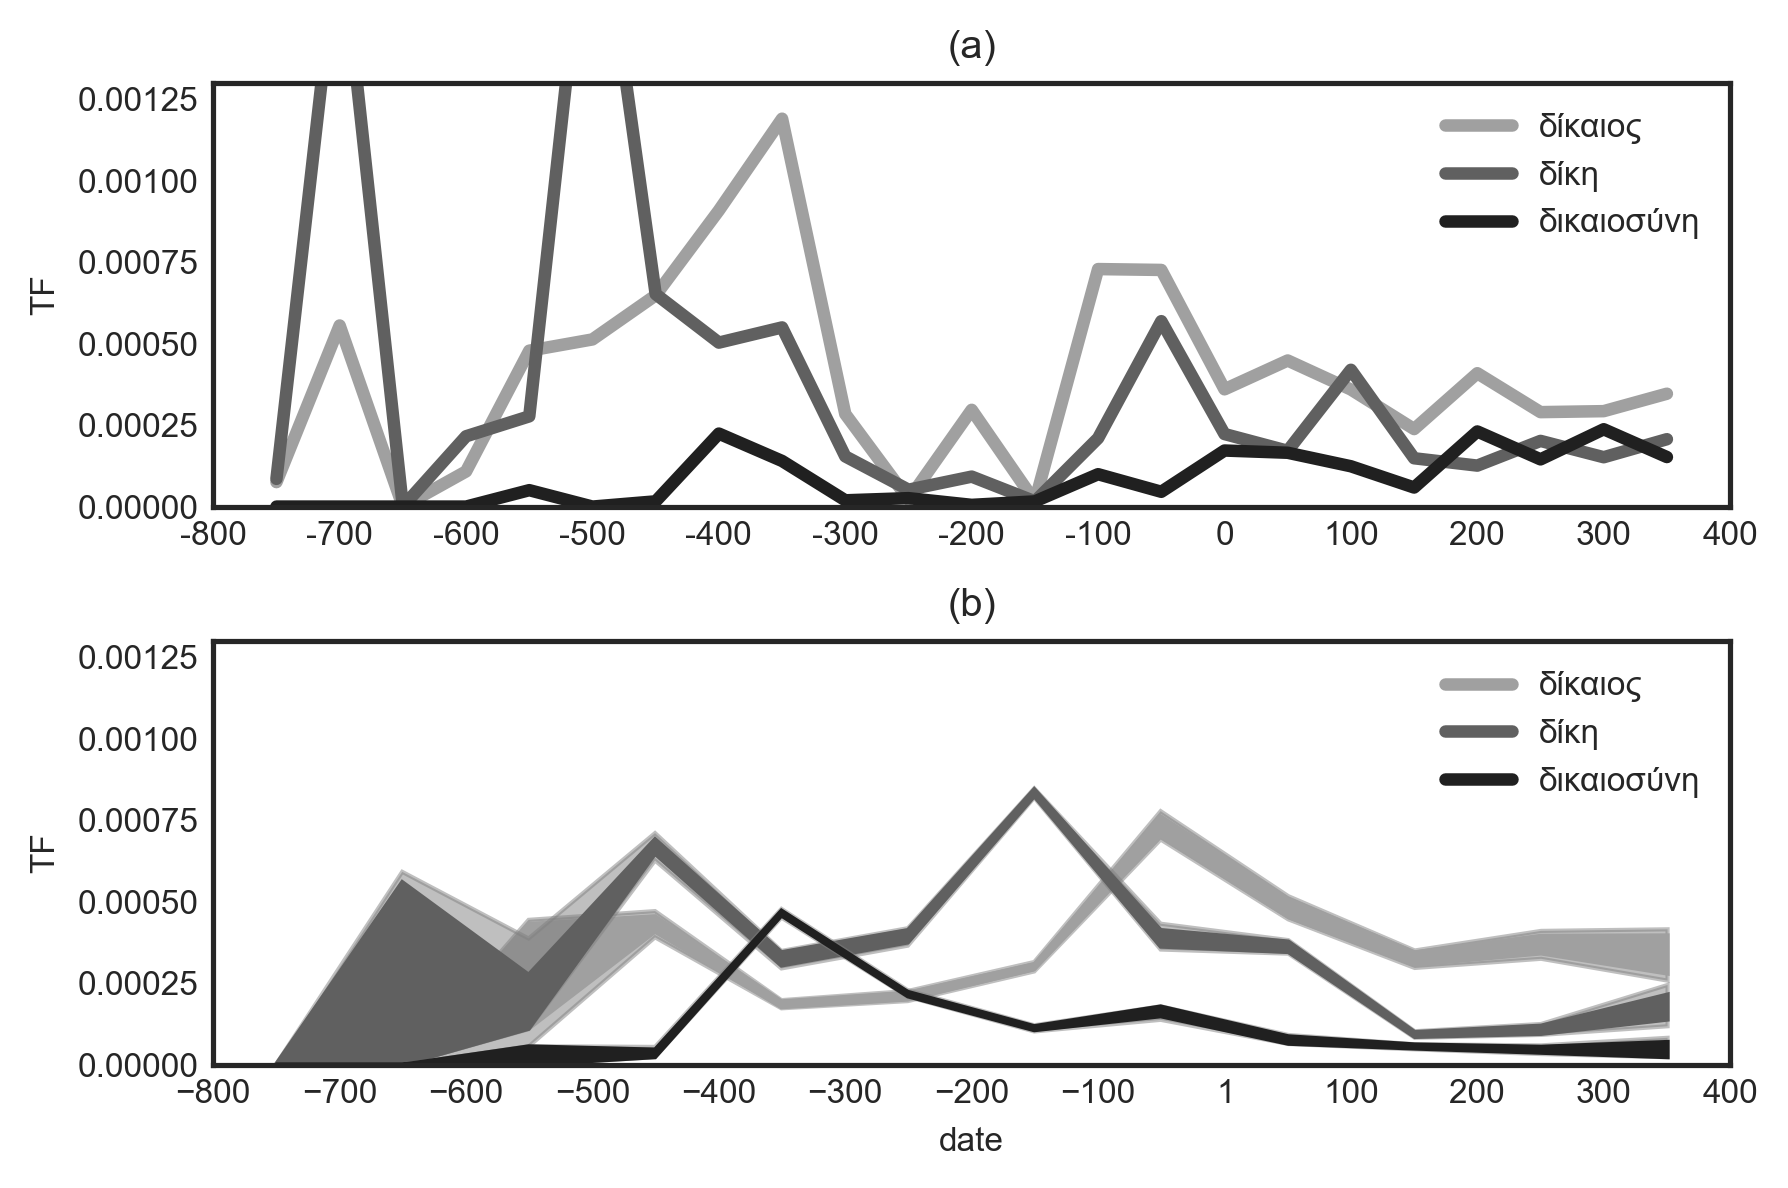

In [87]:
### documents with probabilities
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)


###LAGT
for word, color in zip(words, ["#A0A0A0", "#606060", "#202020"]):
   LAGT_by_avr.plot(x='date_avr', y=word + "_TF", label=word, ax=ax1, color=color, linewidth=3)

ax1.set_xlim(-8, 4)
ax1.set_xlabel("")
ax1.set_xticks(range(-8, 5))
ax1.set_xticklabels([str(n) for n in range(-800, 500, 100)])


ax1.set_ylim(0, 0.0013)
ax1.set_ylabel("TF")

ax1.set_title("(a)")
ax2.legend().set_visible(False)


### PHI
markers = []
for word, color in zip(words, ["#A0A0A0", "#606060", "#202020"]):
    complete_sim_data = sim_data(PHI, 100, tf_in_df, word) 
    layer = tempun.plot_timeblocks_data(complete_sim_data, ax=ax2, color=color)
    markers.append(mlines.Line2D([], [], linewidth=3, label=word, color=color))

ax2.set_xlim(-800, 400)
ax2.set_xticks([n + 1 if n == 0 else n for n in range(-800, 500, 100)])
ax2.set_xlabel("date")

ax2.set_ylim(0, 0.0013)
ax2.set_ylabel("TF")

ax2.set_title("(b)")
ax2.legend(handles=markers)

In [88]:
s.write_file("AGT+PHI_tf.png", fig)
fig.savefig("../figures/AGT+PHI_tf.png")

A file with the same name ("AGT+PHI_tf.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/AGT+PHI_tf.png"
